In [1]:
import os
import pandas as pd
import requests
import time
import json
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import seaborn as sns 

from pygam import LinearGAM, s
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
# --- CONFIG ---
API_KEY = "YwnbHRjcJvf6Md2OPoKbSRGHlzZ7hjR6"
data_folder = os.path.join(os.path.expanduser("~/Desktop/Trading"), "Data")
os.makedirs(data_folder, exist_ok=True)
tickers_csv_file = os.path.join(data_folder, "sp500_tickers.csv")

# --- LOAD FROM CACHE OR FETCH ---
if os.path.exists(tickers_csv_file):
    print("Loading tickers from CSV cache...")
    df_sp500 = pd.read_csv(tickers_csv_file)
else:
    print("Fetching tickers from API...")
    url = f"https://financialmodelingprep.com/api/v3/sp500_constituent?apikey={API_KEY}"
    df_sp500 = pd.DataFrame(requests.get(url).json())

    # Save to CSV
    df_sp500.to_csv(tickers_csv_file, index=False)
    print(f"Saved {len(df_sp500)} tickers to CSV cache.")

    
tickers = df_sp500["symbol"].dropna().unique().tolist()
# --- PREVIEW ---
print(df_sp500.shape)
print(df_sp500.columns)
print(df_sp500.head(5))

Loading tickers from CSV cache...
(503, 8)
Index(['symbol', 'name', 'sector', 'subSector', 'headQuarter',
       'dateFirstAdded', 'cik', 'founded'],
      dtype='object')
  symbol                  name                  sector  \
0    XYZ           Block, Inc.              Technology   
1    TTD  The Trade Desk, Inc.              Technology   
2   DDOG               Datadog              Technology   
3   COIN       Coinbase Global      Financial Services   
4   DASH              DoorDash  Communication Services   

                            subSector              headQuarter dateFirstAdded  \
0           Software - Infrastructure      Oakland, California     2025-07-23   
1              Software - Application      Ventura, California     2025-07-18   
2              Software - Application  New York City, New York     2025-07-09   
3  Financial - Data & Stock Exchanges     Wilmington, Delaware     2025-05-19   
4      Internet Content & Information        San Francisco, CA     2025-03

In [3]:
def fetch_statement(endpoint, tickers, period, limit, data_folder):
    """Fetch statements with unique JSON filename based on endpoint, period, limit."""
    output_file = os.path.join(
        data_folder,
        f"{endpoint}_{period}_limit{limit}.json"
    )

    if os.path.exists(output_file):
        print(f"Loading from cache: {output_file}")
        with open(output_file, "r") as f:
            return json.load(f)

    records = []
    for ticker in tickers:
        url = f"https://financialmodelingprep.com/api/v3/{endpoint}/{ticker}?period={period}&limit={limit}&apikey={API_KEY}"
        try:
            response = requests.get(url)
            response.raise_for_status()
            data = response.json()
            if data:
                for row in data:
                    row["symbol"] = ticker
                records.extend(data)
        except Exception as e:
            print(f"Error fetching {ticker} ({endpoint}): {e}")
        time.sleep(.2)  # API polite rate limit

    with open(output_file, "w") as f:
        json.dump(records, f, indent=2)
    print(f"Saved {len(records)} records to {output_file}")
    return records


income_data_2_years   = fetch_statement("income-statement", tickers, "annual", 2, data_folder)
balance_data_2_years  = fetch_statement("balance-sheet-statement", tickers, "annual", 2, data_folder)
cashflow_data_2_years = fetch_statement("cash-flow-statement", tickers, "annual", 2, data_folder)

# Convert to DataFrames
income_data_2_years   = pd.DataFrame(income_data_2_years)
balance_data_2_years  = pd.DataFrame(balance_data_2_years)
cashflow_data_2_years = pd.DataFrame(cashflow_data_2_years)

print("Income shape:", income_data_2_years.shape)
print("Balance shape:", balance_data_2_years.shape)
print("Cash flow shape:", cashflow_data_2_years.shape)

print(income_data_2_years.columns)
print(balance_data_2_years.columns)
print(cashflow_data_2_years.columns)

Loading from cache: /Users/nicholassanso/Desktop/Trading/Data/income-statement_annual_limit2.json
Loading from cache: /Users/nicholassanso/Desktop/Trading/Data/balance-sheet-statement_annual_limit2.json
Loading from cache: /Users/nicholassanso/Desktop/Trading/Data/cash-flow-statement_annual_limit2.json
Income shape: (1006, 38)
Balance shape: (1006, 54)
Cash flow shape: (1006, 40)
Index(['date', 'symbol', 'reportedCurrency', 'cik', 'fillingDate',
       'acceptedDate', 'calendarYear', 'period', 'revenue', 'costOfRevenue',
       'grossProfit', 'grossProfitRatio', 'researchAndDevelopmentExpenses',
       'generalAndAdministrativeExpenses', 'sellingAndMarketingExpenses',
       'sellingGeneralAndAdministrativeExpenses', 'otherExpenses',
       'operatingExpenses', 'costAndExpenses', 'interestIncome',
       'interestExpense', 'depreciationAndAmortization', 'ebitda',
       'ebitdaratio', 'operatingIncome', 'operatingIncomeRatio',
       'totalOtherIncomeExpensesNet', 'incomeBeforeTax',
  

In [4]:
def sort_by_symbol_date(df):
    return df.sort_values(["symbol", "date"])


def compute_yoy_growth(df, exclude_cols=["symbol", "date","link","finalLink"]):
    numeric_cols = df.select_dtypes(include=[float, int]).columns
    numeric_cols = [c for c in numeric_cols if c not in exclude_cols]
    
    df_growth = df.copy()
    for col in numeric_cols:
        df_growth[col + "_yoy"] = df.groupby("symbol")[col].pct_change()
    
    return df_growth


income_sorted = sort_by_symbol_date(income_data_2_years)
balance_sorted = sort_by_symbol_date(balance_data_2_years)
cashflow_sorted = sort_by_symbol_date(cashflow_data_2_years)

income_growth = compute_yoy_growth(income_sorted)
balance_growth = compute_yoy_growth(balance_sorted)
cashflow_growth = compute_yoy_growth(cashflow_sorted)

In [5]:
def count_zeros_nans_yoy(df):
    # Keep only numeric columns that end with "_yoy"
    numeric_cols = [c for c in df.select_dtypes(include=[float, int]).columns if c.endswith("_yoy")]
    
    # Count zeros and NaNs
    zero_counts = (df[numeric_cols] == 0).sum()
    nan_counts = df[numeric_cols].isna().sum()
    
    # Combine into a single DataFrame
    summary = pd.DataFrame({
        "zeros": zero_counts,
        "nans": nan_counts
    }).sort_values(by=["zeros", "nans"], ascending=True)
    
    # Force full display
    with pd.option_context("display.max_rows", None, "display.max_columns", None):
        print(summary)
    
    return summary

# Example usage
print("Income 0/NaN counts per YoY column:")
income_summary = count_zeros_nans_yoy(income_growth)

print("\nBalance 0/NaN counts per YoY column:")
balance_summary = count_zeros_nans_yoy(balance_growth)

print("\nCashflow 0/NaN counts per YoY column:")
cashflow_summary = count_zeros_nans_yoy(cashflow_growth)

Income 0/NaN counts per YoY column:
                                             zeros  nans
revenue_yoy                                      0   503
grossProfit_yoy                                  0   503
costAndExpenses_yoy                              0   503
ebitdaratio_yoy                                  0   503
operatingIncome_yoy                              0   503
operatingIncomeRatio_yoy                         0   503
incomeBeforeTax_yoy                              0   503
incomeBeforeTaxRatio_yoy                         0   503
netIncomeRatio_yoy                               0   503
ebitda_yoy                                       0   504
operatingExpenses_yoy                            0   507
costOfRevenue_yoy                                0   510
totalOtherIncomeExpensesNet_yoy                  0   535
generalAndAdministrativeExpenses_yoy             0   756
netIncome_yoy                                    1   503
eps_yoy                                          1  

In [8]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

def prepare_for_pca(df, nan_threshold=505, n_components=5):
    # 1. Keep only _yoy numeric columns
    yoy_cols = [c for c in df.select_dtypes(include=[float, int]).columns if c.endswith("_yoy")]
    sub_df = df[yoy_cols].copy()
    
    # 2. Drop columns with too many NaNs
    valid_cols = sub_df.columns[sub_df.isna().sum() <= nan_threshold]
    sub_df = sub_df[valid_cols]
    
    # 3. Replace infinities with NaN
    sub_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # 4. Drop rows with any remaining NaNs
    sub_df.dropna(inplace=True)
    
    # Count how many rows are being used
    row_count = sub_df.shape[0]
    
    # 5. Standardize
    scaler = StandardScaler()
    scaled = scaler.fit_transform(sub_df)
    
    # 6. Run PCA
    pca = PCA(n_components=n_components)
    pcs = pca.fit_transform(scaled)
    
    # Convert back to DataFrame
    pcs_df = pd.DataFrame(
        pcs,
        index=sub_df.index,
        columns=[f"PC{i+1}" for i in range(n_components)]
    )
    
    return pcs_df, pca, scaler, valid_cols, row_count



In [9]:
# Run PCA on Income
income_pcs, income_pca_model, income_scaler, income_used_cols, income_row_count = prepare_for_pca(
    income_growth, nan_threshold=505, n_components=5
)

# Run PCA on Balance
balance_pcs, balance_pca_model, balance_scaler, balance_used_cols, balance_row_count = prepare_for_pca(
    balance_growth, nan_threshold=505, n_components=5
)

# Run PCA on Cashflow
cashflow_pcs, cashflow_pca_model, cashflow_scaler, cashflow_used_cols, cashflow_row_count = prepare_for_pca(
    cashflow_growth, nan_threshold=505, n_components=5
)

# Print summary
print("Income PCA shape:", income_pcs.shape, "| Rows used:", income_row_count)
print("Balance PCA shape:", balance_pcs.shape, "| Rows used:", balance_row_count)
print("Cashflow PCA shape:", cashflow_pcs.shape, "| Rows used:", cashflow_row_count)


Income PCA shape: (502, 5) | Rows used: 502
Balance PCA shape: (489, 5) | Rows used: 489
Cashflow PCA shape: (496, 5) | Rows used: 496


In [10]:
def run_pca_on_selected_yoy_clean(df, selected_yoy_cols, n_components=5, keep_cols=["symbol","date"]):
    """
    df: DataFrame with growth data (includes _yoy columns)
    selected_yoy_cols: list of yoy column names you want to use in PCA
    n_components: number of PCA components
    keep_cols: reference columns to carry over (like symbol, date)
    """
    # Make sure those columns exist
    missing = [c for c in selected_yoy_cols if c not in df.columns]
    if missing:
        raise ValueError(f"Some selected yoy columns not found in DataFrame: {missing}")
    
    # Extract the selected yoy data
    X = df[selected_yoy_cols].copy()
    
    # Replace infinite with NaN
    X = X.replace([np.inf, -np.inf], np.nan)
    
    # Drop any row that has a NaN in any of these selected columns
    mask_valid = ~X.isna().any(axis=1)
    X_clean = X[mask_valid]
    
    # Also keep symbol/date for those same rows
    meta = df.loc[mask_valid, keep_cols].reset_index(drop=True)
    
    # Standardize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_clean)
    
    # Run PCA
    pca = PCA(n_components=n_components)
    components = pca.fit_transform(X_scaled)
    
    # Build PCA DataFrame
    pca_df = pd.DataFrame(components, columns=[f"PCA{i+1}" for i in range(n_components)])
    # Add back symbol/date
    for col in keep_cols:
        if col in meta.columns:
            pca_df[col] = meta[col].values
    
    return pca_df, pca.explained_variance_ratio_


In [11]:
# Example, pick a few yoy columns you trust
income_cols = ["revenue_yoy","netIncome_yoy","ebitda_yoy","operatingIncome_yoy"]
balance_cols = ["totalAssets_yoy","totalLiabilities_yoy","totalStockholdersEquity_yoy"]
cashflow_cols = ["operatingCashFlow_yoy","freeCashFlow_yoy","netCashProvidedByOperatingActivities_yoy"]

income_pca, income_var = run_pca_on_selected_yoy_clean(income_growth, income_cols, n_components=3)
balance_pca, balance_var = run_pca_on_selected_yoy_clean(balance_growth, balance_cols, n_components=3)
cashflow_pca, cashflow_var = run_pca_on_selected_yoy_clean(cashflow_growth, cashflow_cols, n_components=3)


In [12]:
print("Explained variance ratio:", income_var)
print("Total explained variance:", income_var.sum())


Explained variance ratio: [0.29256159 0.25992356 0.23161683]
Total explained variance: 0.7841019824421285


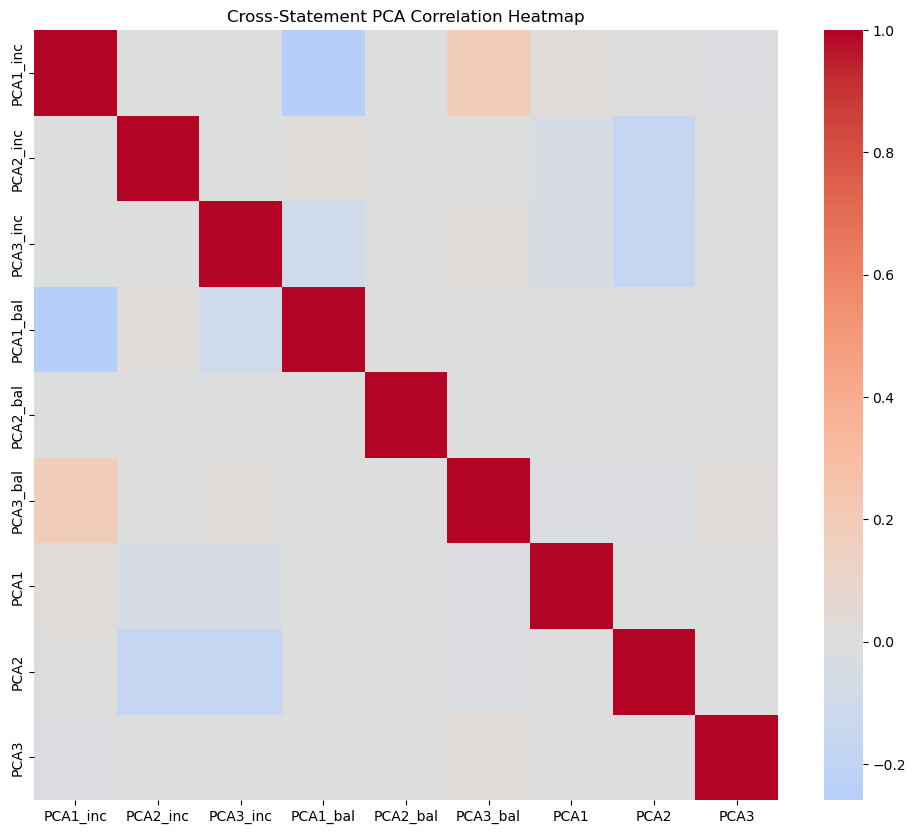

In [13]:
# Merge the three PCA results on symbol/date
merged_pca = income_pca.merge(balance_pca, on=["symbol","date"], suffixes=("_inc", "_bal"))
merged_pca = merged_pca.merge(cashflow_pca, on=["symbol","date"], suffixes=("", "_cf"))

# Get only PCA columns
pca_cols = [c for c in merged_pca.columns if c.startswith("PCA")]

# Compute correlation matrix
corr_all = merged_pca[pca_cols].corr()

# Display as heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_all, annot=False, cmap="coolwarm", center=0)
plt.title("Cross-Statement PCA Correlation Heatmap")
plt.show()
